In [1]:
import numpy as np
import pandas as pd
import joblib
import sys, os
sys.path.insert(0, '/home/monte.flora/python_packages/WoF_post')
sys.path.insert(0, '/home/monte.flora/python_packages/ml_workflow')
sys.path.insert(0, '/home/monte.flora/python_packages/wofs_ml_severe')

from wofs_ml_severe.io.load_ml_models import load_ml_model
from wofs.post.utils import load_yaml
import skexplain 
from skexplain.common.importance_utils import to_skexplain_importance 
from display_names import to_display_name, to_units, to_color, map_to_readable_names

In [2]:
time = 'first_hour'
target = 'tornado_severe_0km'
retro = False

ml_config = load_yaml(
    '/home/monte.flora/python_packages/wofs_ml_severe/wofs_ml_severe/conf/ml_config_retro.yml')

parameters = {
                'target' : target,
                'time' : time, 
                'drop_opt' : '',
                'model_name' : 'LogisticRegression',
                'ml_config' : ml_config,
            }

model_dict = load_ml_model(retro, **parameters)
model = model_dict['model']


ml_config = load_yaml(
    '/home/monte.flora/python_packages/wofs_ml_severe/wofs_ml_severe/conf/ml_config_retro.yml')

parameters['model_name'] = 'LogisticRegression'
parameters['ml_config'] = ml_config
model_dict = load_ml_model(retro, **parameters)
model = model_dict['model']
X =  model_dict['X']
y = model_dict['y']

Loading /work/mflora/ML_DATA/NEW_ML_MODELS/LogisticRegression_tornado_severe_0km_None_first_hour_realtime.joblib...
Loading /work/mflora/ML_DATA/NEW_ML_MODELS/LogisticRegression_tornado_severe_0km_None_first_hour_realtime.joblib...


In [3]:
N = 50000
rs = np.random.RandomState(42)

inds = rs.choice(len(X), size=N)

X_sub = X.iloc[inds, :]
y_sub = y[inds]

X_sub.reset_index(inplace=True, drop=True)


explainer = skexplain.ExplainToolkit(('ML', model), X=X_sub, y=y_sub)

In [4]:
direction = 'backward'
results = explainer.permutation_importance(
                                           n_vars=5, 
                                           evaluation_fn='norm_aupdc',
                                           n_permute=5, 
                                           subsample=1.0,
                                           n_jobs=1,
                                           verbose=True,
                                           random_seed=42, 
                                           direction=direction,
                                              )

fname = f'/work/mflora/ML_DATA/permutation_importance/pi_{target}_{time}_{direction}.nc'
explainer.save(fname, results)

Perm. Imp.: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:12<00:00, 38.46s/it]


In [5]:
results = explainer.load(fname)

display_feature_names = {f : to_display_name(f) for f in results['backward_singlepass_rankings__ML'].values}
feature_colors = {f : to_color(f) for f in results['backward_singlepass_rankings__ML'].values}

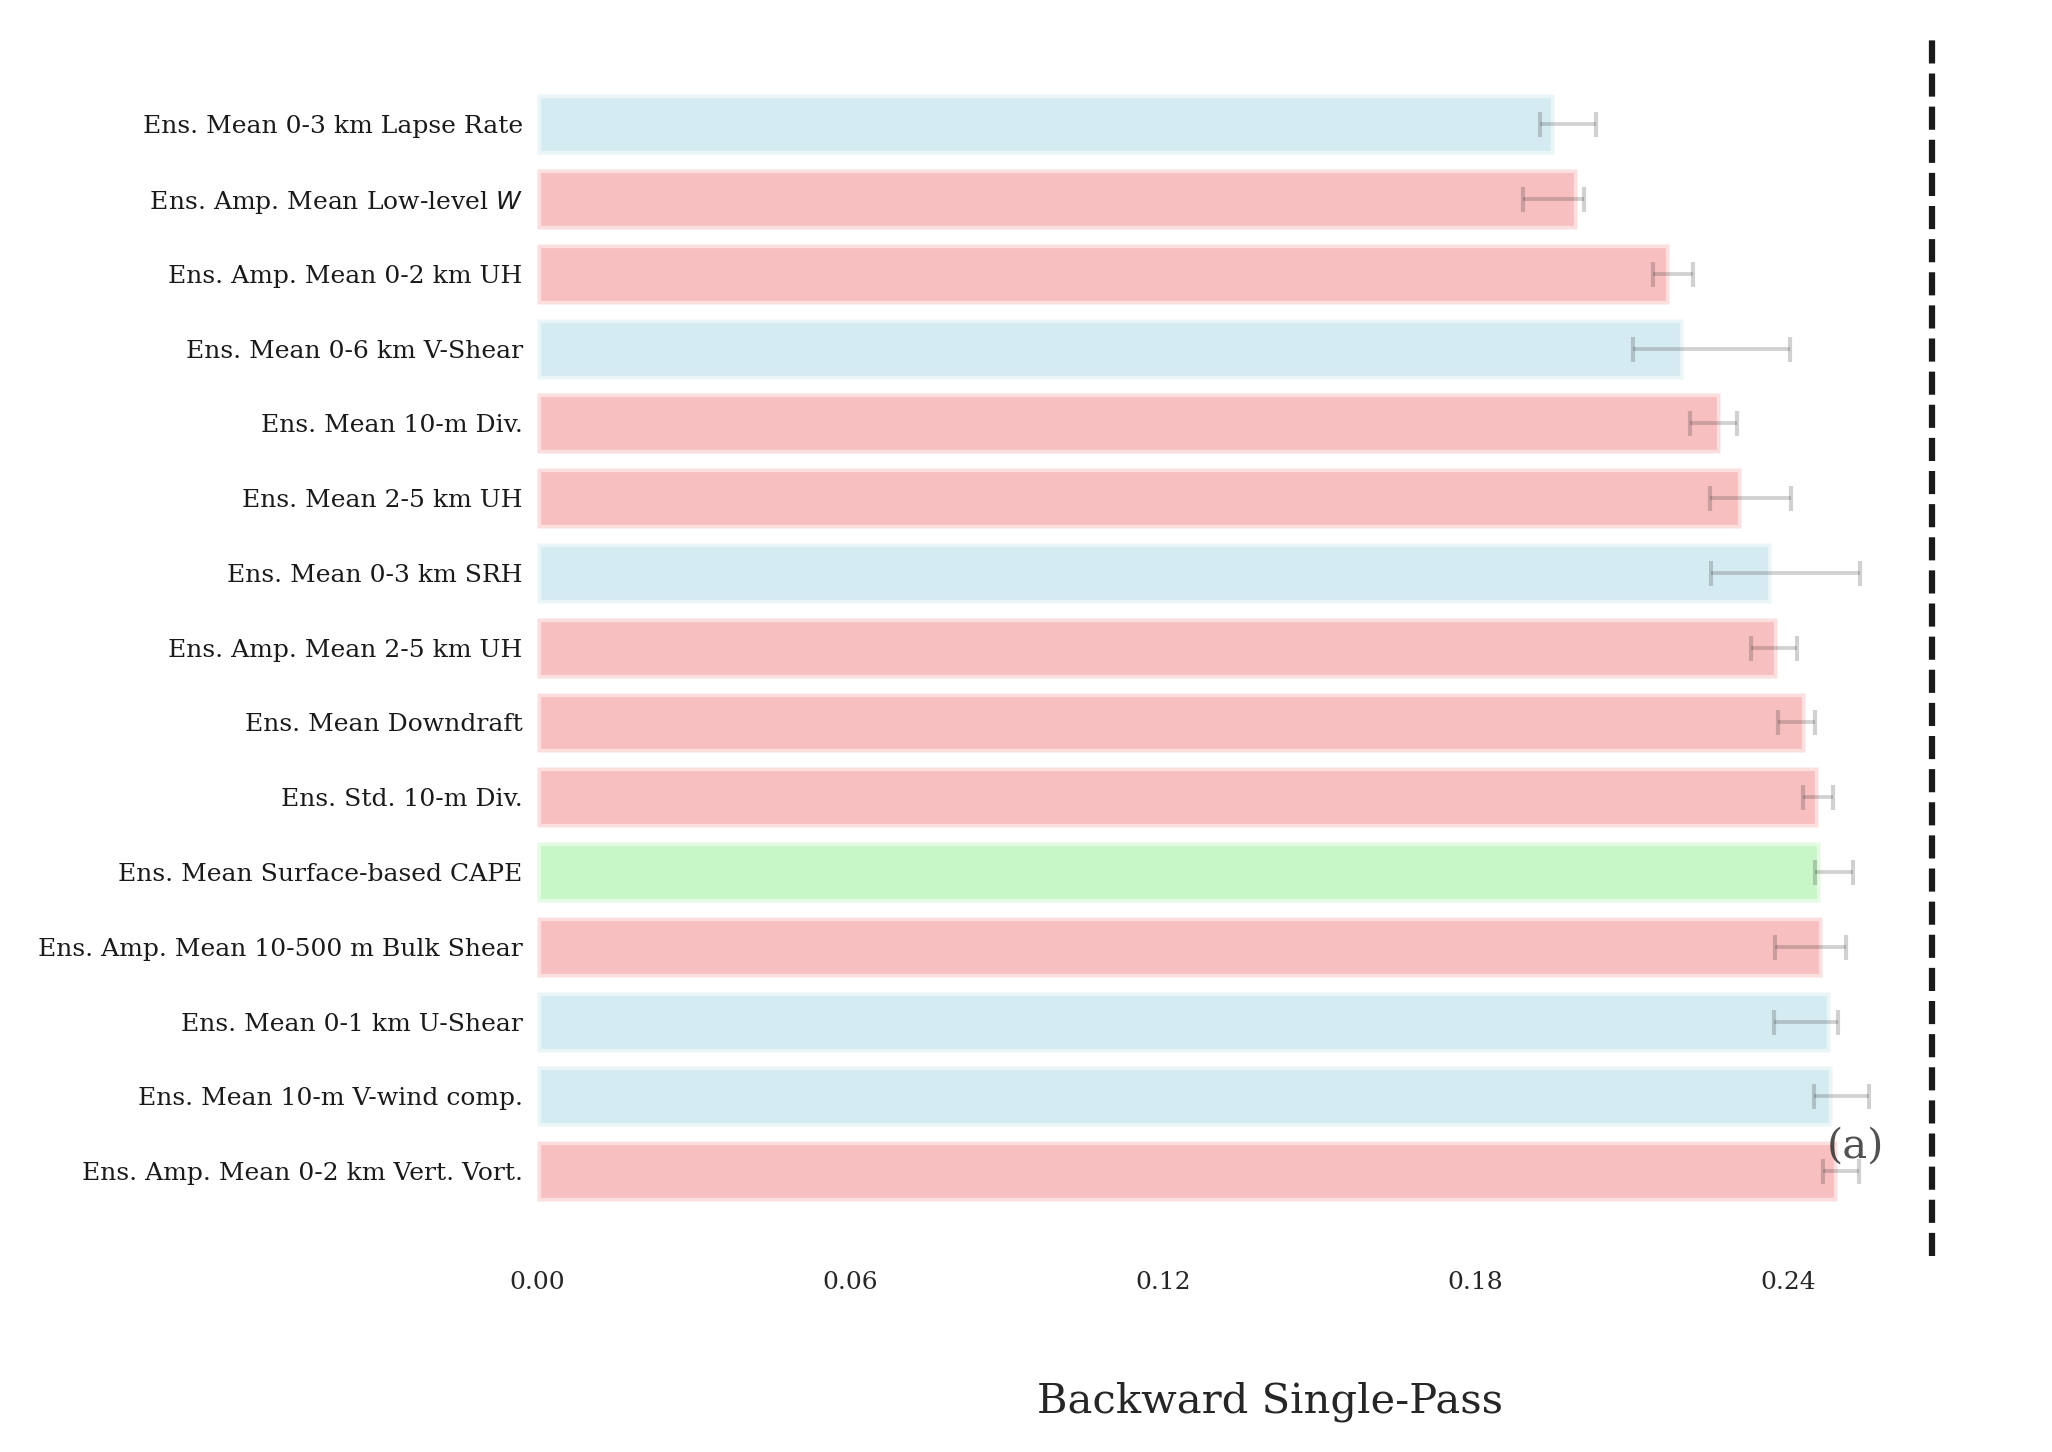

In [6]:
%matplotlib inline
fig = explainer.plot_importance(data=results, 
                                panels=[('backward_singlepass', 'ML')], 
                                num_vars_to_plot=15, 
                                display_feature_names = display_feature_names,
                                feature_colors = feature_colors, 
                                figsize = (7,5)
                                 )

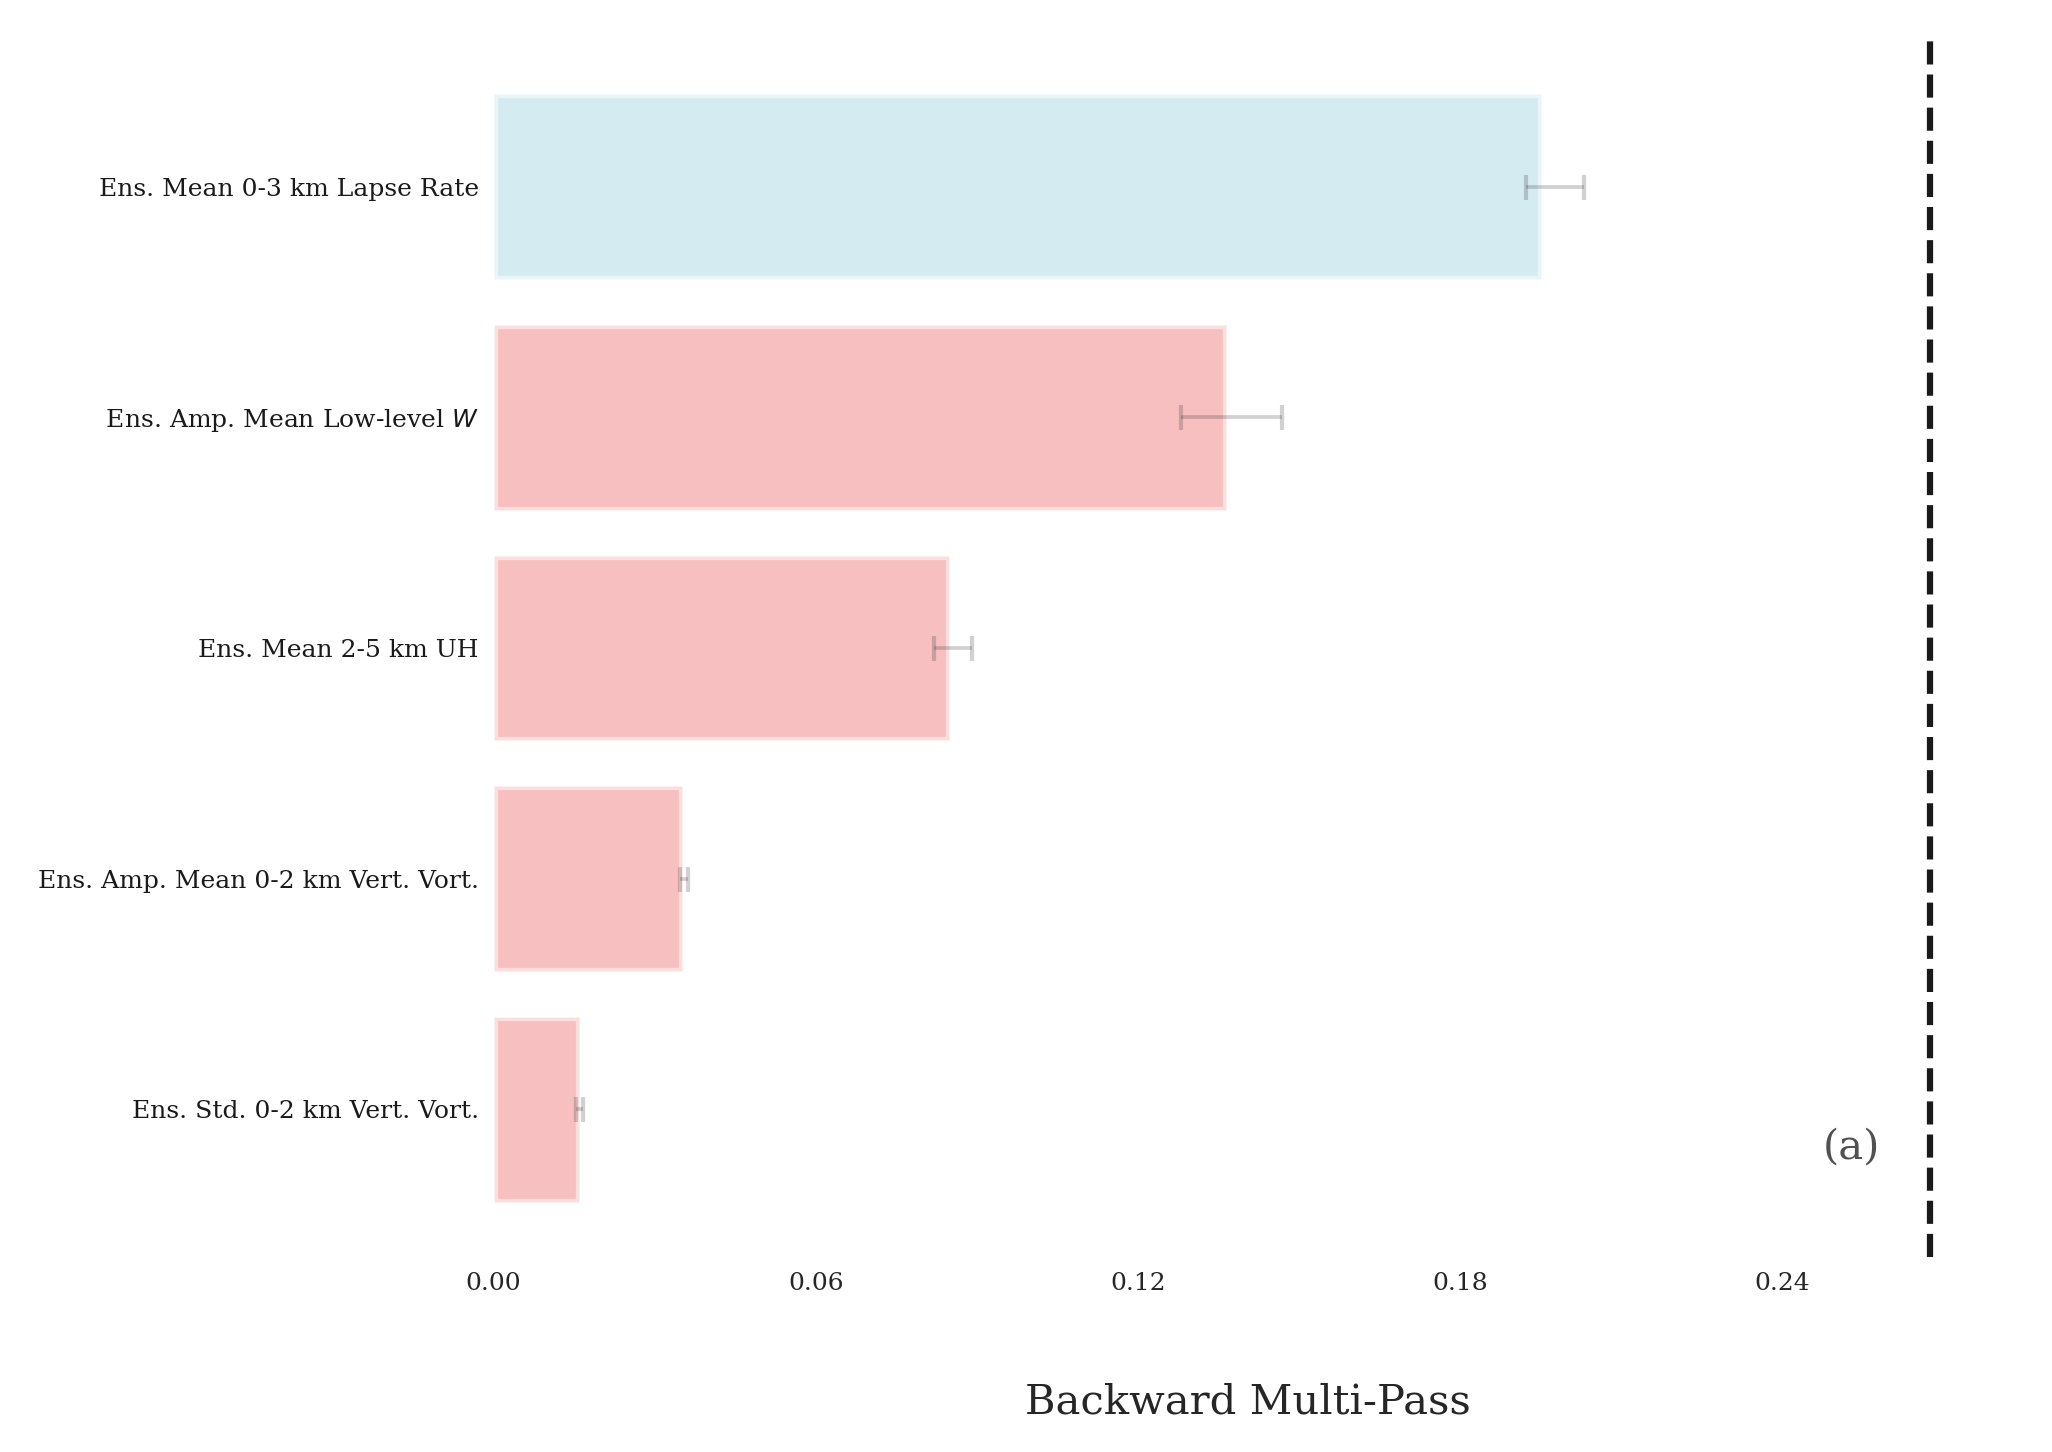

In [7]:
%matplotlib inline
fig = explainer.plot_importance(data=results, 
                                panels=[('backward_multipass', 'ML')], 
                                num_vars_to_plot=5, 
                                display_feature_names = display_feature_names,
                                feature_colors = feature_colors,
                                figsize = (7,5)
                                 )